# Factorizing PSB matrices - varying N

## Supporting Functions

### Functions for generating and checking data

In [11]:
# IMPORTS
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numpy import linalg as LA


# DATA GENERATION AND PERFORMANCE CHECKING FUNCTIONS
def generate_latent(n,k,c1,c2):
    b = c2-c1
    a = c1/b
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    signs = np.sign(np.random.randn(k))
    vals = b*(np.random.rand(k)+a)
    x[locs] = x[locs]*vals*signs
    return x

def generate_exp_dictionary1(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_exp_dictionary2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

def check_dictionary(eps,n,d,A):
    t = (1-4*eps)*d
    mu_A = np.max(np.transpose(A)@A - d*np.identity(n))
    if mu_A >= t:
        print("Generation error, A is not expander for this value of epsilon, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = False
    else:
        print("A passes coherence test, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = True
    return passed  
        
def check_recon_A(A,A_rec,d,eps,n):
    print("Checking reconstruction of A.")
    col_sum = sum(A_rec)
    print(str.format('{0:.1f}',100*len(col_sum[col_sum==d])/n), "% of columns fully formed.")
    print(str.format('{0:.1f}',100*(n - len(col_sum[col_sum==d]) - len(col_sum[col_sum==0]))/n) , "% of columns partially formed.")
    print(str.format('{0:.1f}', 100*len(col_sum[col_sum==0])/n), "% of columns have no entries.")
    overlaps = np.transpose(A_rec)@A
    A_rec_col, A_col = np.where(overlaps>(1-4*eps)*d)
    if len(col_sum[col_sum==0])<n:
        print(str.format('{0:.1f}', 100*len(A_rec_col)/(n - len(col_sum[col_sum==0]))), "% of reconstructed (fully or partially) columns match with a column in target matrix.")  
    error = 0
    missing = 0
    P = np.zeros((n,n))
    for i in range(len(A_rec_col)):
        diff = A_rec[:, A_rec_col[i]] - A[:,A_col[i]]
        error = error + sum(abs(diff[diff==1]))
        missing = missing + sum(abs(diff[diff==-1]))
        P[A_col[i], A_rec_col[i]] = 1
    print(str.format('{0:.0f}', 100*(missing+d*n-len(A_rec_col)*d)/(d*n)), "% of entries missing in total.")
    print(str.format('{0:.0f}', missing), "entries missing in matched columns.")
    print(str.format('{0:.0f}', error), "entries wrong in matched columns.")
    return P
    
def check_recon_X(X,X_rec,P,N,k,n):
    X_perm = P@X_rec
    print("Checking the values of X recovered.")
    tol = 10**-6
    total_entries = N*k
    total_entries_recovered = 0
    correct_loc_correct_val = 0
    correct_loc_wrong_val = 0
    wrong_loc = 0
    missing = 0
    passed = True
    for i in range(N):
        for j in range(n):
            if abs(X[j,i])>tol and abs(X_perm[j,i])>tol:
                error = abs(X[j,i] - X_perm[j,i])
                if error < tol:
                    correct_loc_correct_val +=1
                else:
                    correct_loc_wrong_val += 1
                    print("Column number = ", i, ", row number = ", j, ", true value = ", X[j,i], "value found = ", X_perm[j,i])
            elif abs(X[j,i])>tol and abs(X_perm[j,i])<tol:
                missing += 1
            elif abs(X[j,i])<tol and abs(X_perm[j,i])>tol:
                wrong_loc += 1
    print(str.format('{0:.1f}', 100*(correct_loc_correct_val/total_entries)), "% of entries correctly recovered.")
    print(str.format('{0:.1f}', 100*(correct_loc_wrong_val/total_entries)), "% of entries in correct location but have wrong value for location.")
    print(str.format('{0:.1f}', 100*(missing/total_entries)), "% of entries missing.")
    return X_perm
    

### Auxillary functions

In [12]:
# USED IN BOTH EXPERIMENTS 1 and 2
def xps2(y,x_vals,x_locs,A_rec,m,eps,d,k):
    tol1 = 10**-8
    tol2 = 10**-8
    y_copy = copy.deepcopy(y)
    t = (1-2*eps)*d
    z1 = len(y_copy);
    W = np.zeros((m,k))
    vals = np.zeros(k)
    q = 0
    for i in range(z1):
        if np.abs(y_copy[i])> tol1:
            locs = list()
            locs.append(i)
            for j in range(i+1, m):
                if np.abs(y_copy[j] - y_copy[i]) < tol2:
                    locs.append(j)
                    y_copy[j] = 0
            match = np.where(y_copy[i]==x_vals)[0]
            if not match:
                if len(locs)>t:
                    W[locs,q] = 1
                    vals[q] = y_copy[i]
                    q = q+1
            elif len(match)==1:
                A_rec[locs, x_locs[match[0]]] = 1
            else:
                print('ERROR - column value matches with more than 1 singleton value already extracted')
        y_copy[i] = 0
    W = W[:,:q]
    vals = vals[:q]
    return [W, A_rec, vals, q]

def process_column2(y, A_rec, x, m, eps, d, k, c, dpid):
    exit_flag = True
    tau = (1-4*eps)*d
    x_locs = np.nonzero(x)[0]
    x_vals = np.zeros(len(x_locs))
    for i in range(len(x_locs)):
        x_vals[i] = x[x_locs[i]]  
    [W, A_rec, vals, q] = xps2(y,x_vals,x_locs,A_rec,m,eps,d,k)
    if q > 0:
        match_check = np.zeros(q) 
        match_col_id = -0.5*np.ones(q)
        data_id = dpid*np.ones(q)          
        if c > 0:           
            matches = np.transpose(W)@A_rec
            matches[matches<=tau] = 0
            matches[matches>tau] = 1
            num_matches = matches.sum(axis=1)
            col_ind = matches@np.arange(c)           
            for i in range(q):
                if num_matches[i] == 0:
                    if c>=n:
                        print("Error: trying to add new column which exceeds total number of columns")
                        exit_flag==False
                elif num_matches[i] == 1:
                    match_check[i] = 1                   
                    z = int(col_ind[i])
                    match_col_id[i] = z
                elif num_matches[i] > 1:
                    print("Error: partial support matches with ", num_matches[i]," partially reconstructed columns of A.")
                    exit_flag = False
    else:
        exit_flag = False
        match_check = []
        match_col_id = []
        data_id = []
    return [W, A_rec, match_check, match_col_id, data_id, vals, exit_flag]

def sort_unmatched_columns(W, eps, d, c): 
    q = W.shape[1]
    col_id_new = -0.5*np.zeros(q)
    tau = (1-4*eps)*d
    matches = np.transpose(W)@W
    matches[matches<=tau] = 0
    matches[matches>tau] = 1
    i =0
    while i<q:
        if sum(matches[:,i]) > 0:
            temp = np.where(matches[:,i]==1)[0]
            col_id_new[temp] = c
            c +=1
            for j in range(len(temp)):
                matches[temp[j],:] = np.zeros(q)
                matches[:,temp[j]] = np.zeros(q)
        i +=1
    return [col_id_new, c]

def update_reconstruction(W, col_id, data_id, vals, A_rec, X_rec):
    for i in range(len(col_id)):
        A_rec[:, int(col_id[i])] += W[:,i]
        X_rec[int(col_id[i]), int(data_id[i])] = vals[i]
    A_rec[A_rec>0] = 1
    return [A_rec, X_rec]

def l0_decode(y, A, num_comp, alpha):
    tol = 10**-3
    tol2 = 10**-9
    converged = False
    r = copy.deepcopy(y)
    r_old = copy.deepcopy(y)
    x = np.zeros(num_comp)
    iters=1
    while converged == False and iters<10:
        vals = np.unique(r)
        vals = vals[vals!=0]
        for j in range(num_comp):
            r_0 = np.count_nonzero(r)
            for v in np.nditer(vals):
                u = r - v*A[:,j]
                u_0 = np.count_nonzero(u)
                if r_0 - u_0 >= alpha:
                    x[j] = x[j] + v
            r = y - A@x
            r[np.absolute(r)<tol2]=0
        if LA.norm(r - r_old) <= LA.norm(r_old)*tol or LA.norm(r)<=LA.norm(y)*tol:
            converged = True
        else:
            r_old = copy.deepcopy(r)
            iters +=1
        if iters == 10:
            print("Warning: max number of iterations of while loop in l0 decode step reached.")
            print('Percentage improvement in residual from penultimate iteration: ', str.format('{0:.5f}', LA.norm(r - r_old)))
            print('Size of final residual: ' ,  str.format('{0:.5f}', LA.norm(r)))
    return x

### EBF Algorithm

In [13]:
def EBF(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob):
    epoch = 0
    c = 0
    tol = 10**-8 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)            
            if supports_found == True:
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)
            R = Y - A_rec@X_rec
            R[np.absolute(R)<tol] = 0
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

In [14]:
def EBF_l0(Y,N,m,n,d,k,eps,max_epochs,A_sparsity,X_sparsity,Y_frob, alpha):
    epoch = 0
    c = 0
    tol = 10**-8 # make sure is smaller than 1
    exit_program=False  
    A_rec = np.zeros((m,n))
    X_rec = np.zeros((n,N))
    frob_error_series = np.ones(max_epoch)
    A_entries = np.zeros(max_epoch)
    X_entries = np.zeros(max_epoch)
    total_entries = np.zeros(max_epoch)
    R = copy.deepcopy(Y)    
    start_time = timer()
    while epoch < max_epoch and frob_error_series[epoch] > tol and exit_program==False:            
        num_matched = 0
        num_new = 0    
        for i in range(N):
            [W, A_rec[:,:c], match_check, match_col_id, data_id, vals, supports_found]=process_column2(R[:,i], A_rec[:,:c], X_rec[:,i], m, eps, d, k, c, i)
            if supports_found == True:
                matches = np.where(match_check==1)[0]
                new = np.where(match_check==0)[0]
                if len(matches)>0:
                    if num_matched > 0:
                        W_match = np.concatenate((W_match, W[:,matches]), axis=1)
                        col_id_match = np.concatenate((col_id_match, match_col_id[matches]), axis=0)
                        data_id_match = np.concatenate((data_id_match, data_id[matches]), axis=0)
                        val_match = np.concatenate((val_match, vals[matches]), axis=0)
                    else:
                        W_match = W[:,matches]
                        col_id_match = match_col_id[matches]
                        data_id_match = data_id[matches]
                        val_match = vals[matches]
                        num_matched += W_match.shape[1]

                if len(new)>0:
                    if num_new > 0:
                        W_new = np.concatenate((W_new, W[:,new]), axis=1)
                        data_id_new = np.concatenate((data_id_new, data_id[new]), axis=0)
                        val_new = np.concatenate((val_new, vals[new]), axis=0)
                    else:
                        W_new = W[:,new]
                        data_id_new = data_id[new]
                        val_new = vals[new]
                        num_new += W_new.shape[1]

        if num_matched > 0 and num_new > 0:
            [col_id_new, c] = sort_unmatched_columns(W_new, eps, d, c)       
            W_all = np.concatenate((W_match, W_new), axis=1)
            col_id_all = np.concatenate((col_id_match, col_id_new), axis=0)
            data_id_all = np.concatenate((data_id_match, data_id_new), axis=0)
            val_all = np.concatenate((val_match, val_new), axis=0)          
        elif num_matched > 0 and num_new == 0:
            W_all = W_match
            col_id_all = col_id_match
            data_id_all = data_id_match
            val_all = val_match     
        elif num_matched == 0 and num_new > 0:
            [col_id_all, c] = sort_unmatched_columns(W_new, eps, d, c)
            W_all = W_new
            data_id_all = data_id_new
            val_all = val_new                       
        elif num_matched == 0 and num_new == 0:
            print("No partial supports recovered, terminating algorithm")
            frob_error_series[epoch:] = frob_error_series[epoch-1]
            A_entries[epoch:] = A_entries[epoch-1]
            X_entries[epoch:] = X_entries[epoch-1]
            total_entries[epoch:] = total_entries[epoch-1]
            exit_program = True    
        
        if exit_program == False:
            [A_rec, X_rec] = update_reconstruction(W_all, col_id_all, data_id_all, val_all, A_rec, X_rec)  
          
            ### RUN l-0 HERE using completed columns ####            
            # Identify the completed columns of A at this iteration
            col_sumA = np.sum(A_rec, axis = 0)
            col_sumA[col_sumA != d] = 0
            comp = np.nonzero(col_sumA)[0]
            num_comp = len(comp)
            
            # Compute the residual based on the completed columns only
            R_l0 = Y - A_rec[:,comp]@X_rec[comp, :]
            R_l0[np.absolute(R_l0)<tol] = 0 
            # Identify which columns of the residual need to still try and decode
            col_sumR = np.sum(np.absolute(R_l0), axis = 0)
            col_sumR[np.absolute(col_sumR) < tol] = 0
            not_dec = np.nonzero(col_sumR)[0]
            num_2_process = len(not_dec)
            
            print("Running l0 decode on epoch ", str.format('{0:.0f}', epoch+1), ': n. of data points of Y still to decode = ', str.format('{0:.0f}', num_2_process), ", n. columns of A completed = ", str.format('{0:.0f}', num_comp),)       
            # Iterate through each column in turn and run l0 decode
            for j in range(num_2_process):
                X_l0_update = l0_decode(R_l0[:,not_dec[j]], A_rec[:,comp], num_comp, alpha)
                X_rec[comp, not_dec[j]] = X_rec[comp, not_dec[j]] + X_l0_update
                if np.mod(int(not_dec[j]),np.ceil(num_2_process/5)) == 0:
                    print("Processed ", str.format('{0:.0f}', j), " data points out of ", str.format('{0:.0f}', num_2_process))
            ############################################   
            
            R = Y - A_rec@X_rec
            R[np.absolute(R)<tol] = 0            
            frob_error_series[epoch] = np.sqrt(sum(sum(R**2)))
            A_entries[epoch] = np.count_nonzero(A_rec)
            X_entries[epoch] = np.count_nonzero(X_rec)
            total_entries[epoch] = A_entries[epoch] + X_entries[epoch]    
            print('Epoch ', str.format('{0:.0f}', epoch), " processed, l_2 error = ", str.format('{0:.2f}', 100*frob_error_series[epoch]/Y_frob), '%, A l_0 error =', str.format('{0:.2f}', 100*(A_sparsity - A_entries[epoch])/A_sparsity), '%, X l_0 error =', str.format('{0:.2f}', 100*(X_sparsity - X_entries[epoch])/X_sparsity), '%.')
            if epoch == max_epoch:
                print("Maximum number of epochs reached.")
            epoch +=1
    
    end_time = timer()
    comp_time = end_time - start_time
    return [A_rec, X_rec, frob_error_series, total_entries, A_entries, X_entries, comp_time]

# Analyzing performance of EBF while varying k

## Generate synthetic data to run algorithms on

#### Generating a valid dictionary and data

In [15]:
# Dictionary parameters parameters
n = 1200
# beta = 900

m = 900
d = 10;
eps = 1/6;
N = 200


# Generate a dictionary and check that passes necessary test.
num_generations = 0
passed = False
while passed==False and num_generations < 100:
    A = generate_exp_dictionary2(m,n,d);
    passed = check_dictionary(eps,n,d,A)
    num_generations += 1
if passed == True:
    print("Generated dictionary that passes the coherency test")
else:
    print("Failed to generate dictionary that passes the coherency test, consider different parameters")

A_sparsity = np.count_nonzero(A)

A passes coherence test, mu_A =  3.00 , tau =  3.33 .
Generated dictionary that passes the coherency test


#### Generate data using dictionary

In [16]:
##### GENERATE LATENT REPRESENTATION
b1=1;
b2=5;
# k = [int(np.ceil(0.01*n)), int(np.ceil(0.04*n)), int(np.ceil(0.07*n)), int(np.ceil(0.1*n))]
k = [int(np.ceil(0.01*n)), int(np.ceil(0.03*n)), int(np.ceil(0.05*n)), int(np.ceil(0.07*n))]
X = np.zeros((len(k), n, N))
Y = np.zeros((len(k), m, N))
Y_frob = np.zeros(len(k))
X_sparsity = np.zeros(len(k))
number_k_to_process = len(k)

for j in range(len(k)):
    for i in range(N):
        X[j,:,i] = generate_latent(n,k[j],b1,b2)
    Y[j] = A@X[j]
    Y_frob[j] = np.sqrt(sum(sum(Y[j]**2)))
    X_sparsity[j] = k[j]*N

## Check that l0 function is working as it should be

In [17]:
ind = 3
alpha=3
N_check = 1

Z = np.zeros((n, N_check))
offset = 28


for j in range(N_check):
    Z[:,j] = l0_decode(Y[ind,:,offset+j], A, n, alpha)
    if np.mod(j,np.ceil(N_check/10)) == 0:
        print(j)
        
check_recon_X(X[ind,:,offset:offset+N_check],Z,np.eye(n),N_check,k[ind],n)

0
Checking the values of X recovered.
100.0 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
0.0 % of entries missing.


array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

## Running EBF to recover A and X varying $k/n$

In [18]:
if passed == True:
    eps = 1/6;
    max_epoch = 8
    tol = 10**-8    
    comp_time = np.zeros(len(k))   
    A_rec = np.zeros((len(k),m,n))
    X_rec = np.zeros((len(k),n,N))
    frob_error_series = np.ones((len(k), max_epoch))
    A_entries = np.zeros((len(k), max_epoch))
    X_entries = np.zeros((len(k), max_epoch))
    total_entries = np.zeros((len(k), max_epoch))
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))       
        [A_rec[j], X_rec[j], frob_error_series[j], total_entries[j], A_entries[j], X_entries[j], comp_time[j]] = EBF(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j])
        print("")
        P = check_recon_A(A, A_rec[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  1.0 %, N =  200
Epoch  0  processed, l_2 error =  18.43 %, A l_0 error = 16.02 %, X l_0 error = 1.62 %.
Epoch  1  processed, l_2 error =  6.41 %, A l_0 error = 13.37 %, X l_0 error = 0.00 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
80.8 % of columns fully formed.
6.8 % of columns partially formed.
12.4 % of columns have no entries.
100.0 % of reconstructed (fully or partially) columns match with a column in target matrix.
13 % of entries missing in total.
97 entries missing in matched columns.
0 entries wrong in matched columns.

Checking the values of X recovered.
100.0 % of entries correctly recovered.
0.0 % of entries in correct location but have wrong value for location.
0.0 % of entries missing.

Solving problem with k/n =  3.0 %, N =  200
Epoch  0  processed, l_2 error =  60.94 %, A l_0 error = 5.06 %, X l_0 error = 37.04 %.
Epoch  1  processed, l_2 error =  32.52 %, A l_0 error = 1.22 %, X l_0 error = 10.93 %

Running times:
k/n=1.0 %, 8.50630529295 s
k/n=3.0 %, 39.285157838 s
k/n=5.0 %, 189.910681854 s


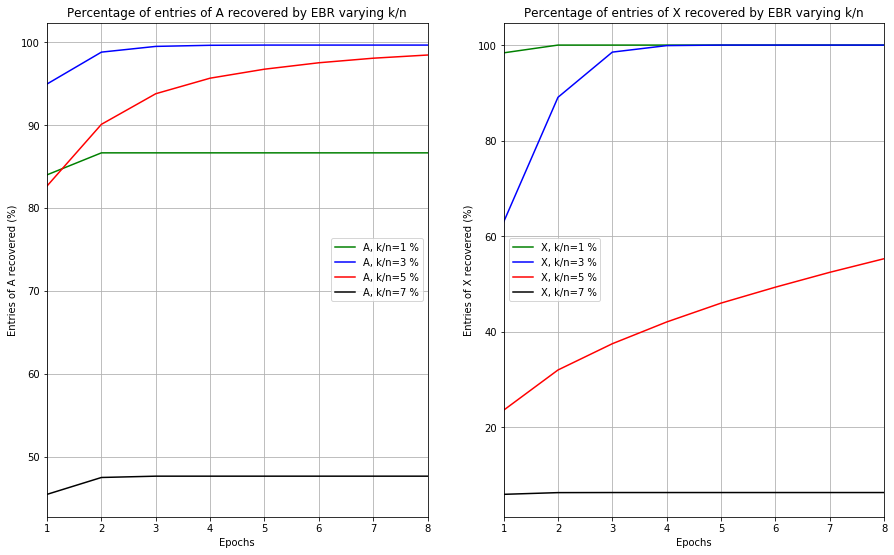

In [19]:
plt.figure(1).clear()

plot_A_entries = 100*A_entries/A_sparsity

plot_X_entries = np.zeros((len(k), max_epoch))
plot_frob = np.zeros((len(k), max_epoch))

for j in range(number_k_to_process):
    plot_X_entries[j,:] = 100*X_entries[j,:]/X_sparsity[j]
plot_epoch = max_epoch

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(1)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[3], 'k-', label="A, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBF varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g-',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b-',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r-',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[3], 'k-',label="X, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of X recovered by EBF varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
# plt.savefig('./figures_ACHA/EBF_performance.eps', format='eps', bbox_inches='tight')

## Running l0-EBF to recover A and X varying $k/n$

In [20]:
# Extra parameters required for l0-EBF
alpha=3

# Run EB interweaved with l-0 decode
if passed == True:
    eps = 1/6;
    tol = 10**-8
    comp_time_l0 = np.zeros(len(k))
    A_rec_l0 = np.zeros((len(k),m,n))
    X_rec_l0 = np.zeros((len(k),n,N))
    frob_error_series_l0 = np.ones((len(k), max_epoch))
    A_entries_l0 = np.zeros((len(k), max_epoch))
    X_entries_l0 = np.zeros((len(k), max_epoch))
    total_entries_l0 = np.zeros((len(k), max_epoch))   
    for j in range(number_k_to_process):
        print("Solving problem with k/n = ", str.format('{0:.1f}', 100*k[j]/n), '%, N = ', str.format('{0:.0f}', N))
        [A_rec_l0[j], X_rec_l0[j], frob_error_series_l0[j], total_entries_l0[j], A_entries_l0[j], X_entries_l0[j], comp_time_l0[j]] = EBF_l0(Y[j],N,m,n,d,k[j],eps,max_epoch,A_sparsity,X_sparsity[j],Y_frob[j],alpha)
        print("")
        P = check_recon_A(A, A_rec_l0[j],d,eps,n)
        print("")
        check_recon_X(X[j],X_rec_l0[j],P,N,k[j],n)
        print("")

Solving problem with k/n =  1.0 %, N =  200
Running l0 decode on epoch  1 : n. of data points of Y still to decode =  161 , n. columns of A completed =  785
Processed  0  data points out of  161
Processed  26  data points out of  161
Processed  53  data points out of  161
Processed  79  data points out of  161
Processed  107  data points out of  161
Processed  136  data points out of  161
Processed  159  data points out of  161
Epoch  0  processed, l_2 error =  15.44 %, A l_0 error = 16.02 %, X l_0 error = 0.54 %.
Running l0 decode on epoch  2 : n. of data points of Y still to decode =  60 , n. columns of A completed =  963
Processed  0  data points out of  60
Processed  21  data points out of  60
Processed  38  data points out of  60
Processed  46  data points out of  60
Epoch  1  processed, l_2 error =  6.17 %, A l_0 error = 13.30 %, X l_0 error = 0.00 %.
No partial supports recovered, terminating algorithm

Checking reconstruction of A.
80.9 % of columns fully formed.
6.7 % of colum

Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  9.39068
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  7.80624
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  10.49416
Processed  38  data points out of  192
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  17.63136
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  9.36442
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  7.21529
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  7.02090
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  11.82849
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  9.12688
Percentage im

Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  10.94713
Processed  4  data points out of  48
Processed  6  data points out of  48
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  20.98833
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  14.43058
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  7.87990
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  43.83008
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  7.82143
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  29.72827
Processed  26  data points out of  48
Processed  31  data points out of  48
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  9.40696
Perce

Running l0 decode on epoch  3 : n. of data points of Y still to decode =  200 , n. columns of A completed =  541
Processed  0  data points out of  200
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  61.53924
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  71.26982
Processed  40  data points out of  200
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  68.41816
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  71.14446
Processed  80  data points out of  200
Processed  120  data points out of  200
Processed  160  data points out of  200
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  71.70294
Epoch  2  processed, l_2 error =  69.09 %, A l_0 error = 19.18 %, X l_0 error = 47.42 %.
Running l0 decode on epoch  4 : n. of data points of Y still to decode =

Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  20.17866
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  23.17402
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  21.71061
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  17.25498
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  19.42336
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  31.47134
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  21.99226
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  19.08211
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  17.18674
Processed  120  data points out of  200
Percen

Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  21.53686
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  27.64266
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  12.55245
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  11.69851
Processed  29  data points out of  87
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  37.45485
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  22.41481
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  6.93797
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  7.68677
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  12.59461
Percentage

Processed  13  data points out of  40
Processed  14  data points out of  40
Processed  20  data points out of  40
Processed  21  data points out of  40
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  51.95291
Processed  22  data points out of  40
Processed  25  data points out of  40
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  37.29540
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  59.92339
Processed  35  data points out of  40
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  21.76298
Epoch  6  processed, l_2 error =  11.78 %, A l_0 error = 0.03 %, X l_0 error = 0.01 %.
Running l0 decode on epoch  8 : n. of data points of Y still to decode =  34 , n. columns of A completed =  1198
Percentage improvement in residual from penultimate iteration:  0.00000
Size of final residual:  53.32223
Proc

Running times:
k/n=1.0 %, 8.50630529295 s
k/n=3.0 %, 39.285157838 s
k/n=5.0 %, 189.910681854 s


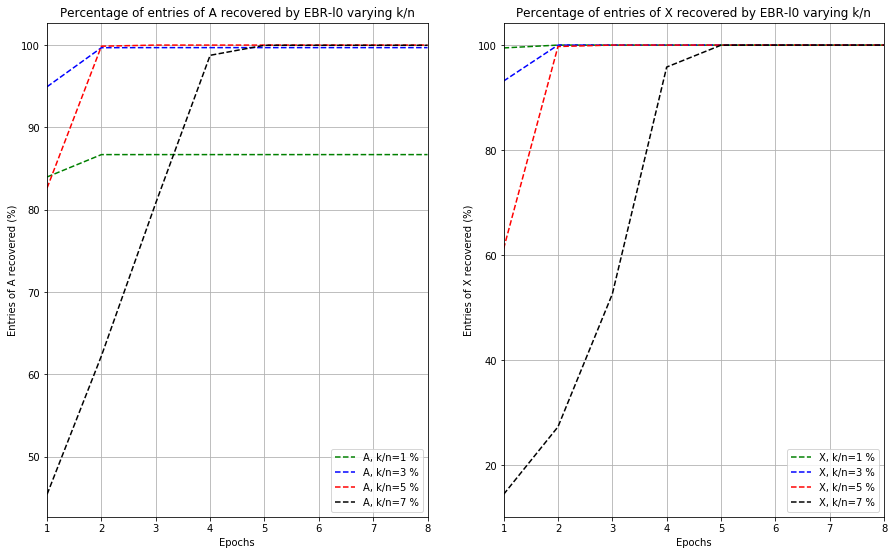

In [21]:
plt.figure(2).clear()

plot_X_entries_l0 = np.zeros((len(k), max_epoch))
plot_A_entries_l0 = 100*A_entries_l0/A_sparsity

for j in range(number_k_to_process):
    plot_X_entries_l0[j,:] = 100*X_entries_l0[j,:]/X_sparsity[j]

plot_epoch = max_epoch

print("Running times:")
print("k/n=%s %%, %s s"%(100*k[0]/n, comp_time[0]))
print("k/n=%s %%, %s s"%(100*k[1]/n, comp_time[1]))      
print("k/n=%s %%, %s s"%(100*k[2]/n, comp_time[2]))  

plt.figure(2)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[0], 'g--', label="A, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[1], 'b--', label="A, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[2], 'r--', label="A, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[3], 'k--', label="A, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by l0-EBF varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[0], 'g--',label="X, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[1], 'b--',label="X, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[2], 'r--',label="X, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[3], 'k--',label="X, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of X recovered by l0-EBF varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.savefig('./figures_ACHA/EBF_l0_performance.eps', format='eps', bbox_inches='tight')

## Side by side comparison of EBF vs l0-EBF

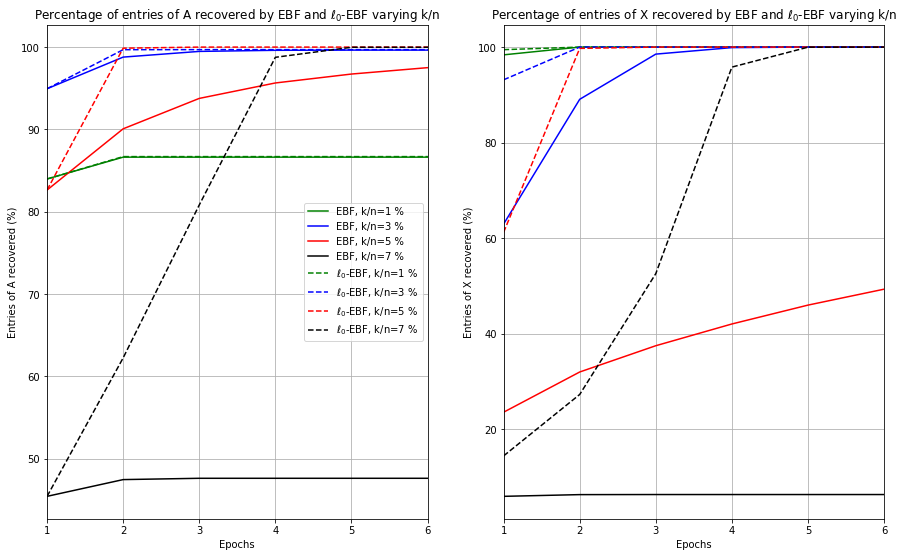

In [22]:
plot_epoch = 6

plt.figure(3)
plt.figure(figsize=(15,20))
plt.subplot(2,2,1)
plt.plot(np.arange(max_epoch)+1, plot_A_entries[0], 'g-', label="EBF, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[1], 'b-', label="EBF, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[2], 'r-', label="EBF, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries[3], 'k-', label="EBF, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[0], 'g--', label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[1], 'b--', label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[2], 'r--', label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_A_entries_l0[3], 'k--', label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of A recovered by EBF and ${\ell_0}$-EBF varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of A recovered (%)')
plt.xlim(1,plot_epoch)
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(max_epoch)+1, plot_X_entries[0], 'g-',label="EBF, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[1], 'b-',label="EBF, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[2], 'r-',label="EBF, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries[3], 'k-',label="EBF, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[0], 'g--',label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[0]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[1], 'b--',label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[1]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[2], 'r--',label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[2]/n, 0))))
plt.plot(np.arange(max_epoch)+1, plot_X_entries_l0[3], 'k--',label="${\ell_0}$-EBF, k/n=%s %%"%(int(round(100*k[3]/n, 0))))
plt.grid(True)
plt.title('Percentage of entries of X recovered by EBF and ${\ell_0}$-EBF varying k/n')
plt.xlabel('Epochs')
plt.ylabel('Entries of X recovered (%)')
plt.xlim(1,plot_epoch)
# plt.legend()
plt.savefig('./figures_ACHA/EBF_vs_EBF_l0_comparison_k.eps', format='eps', bbox_inches='tight')